<h1 align="center"> Theft Detection Using Smart Meter Analysis </h1>

In [1]:
## importing libraries
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import gc
#import optuna
from tqdm.notebook import tqdm as tn
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
#from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, auc, roc_curve

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

%matplotlib inline

In [2]:
#loading data
daily = pd.read_csv("daily_dataset.csv")


In [3]:
daily

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
0,MAC000131,2011-12-15,0.4850,0.432045,0.868,22,0.239146,9.505,0.072
1,MAC000131,2011-12-16,0.1415,0.296167,1.116,48,0.281471,14.216,0.031
2,MAC000131,2011-12-17,0.1015,0.189812,0.685,48,0.188405,9.111,0.064
3,MAC000131,2011-12-18,0.1140,0.218979,0.676,48,0.202919,10.511,0.065
4,MAC000131,2011-12-19,0.1910,0.325979,0.788,48,0.259205,15.647,0.066
...,...,...,...,...,...,...,...,...,...
3510428,MAC004977,2014-02-24,0.0950,0.118458,0.580,48,0.093814,5.686,0.052
3510429,MAC004977,2014-02-25,0.0675,0.084208,0.176,48,0.037107,4.042,0.046
3510430,MAC004977,2014-02-26,0.1080,0.120500,0.282,48,0.069332,5.784,0.046
3510431,MAC004977,2014-02-27,0.0720,0.114062,0.431,48,0.094482,5.475,0.047


In [4]:
## now definding the unique customer present in data
daily.nunique()

LCLid               5566
day                  829
energy_median      10015
energy_mean       358607
energy_max          6425
energy_count          44
energy_std       3127706
energy_sum        391015
energy_min          2149
dtype: int64

In [5]:
daily.isnull().sum()

LCLid                0
day                  0
energy_median       30
energy_mean         30
energy_max          30
energy_count         0
energy_std       11331
energy_sum          30
energy_min          30
dtype: int64

We have total 5566 ids now we filter those instances which have very less daily count

## 2. Data Analysis and Preprocessing

#### ID analysis on basis of half_hourly count
Max Total half hourly count per day must be 48 for each daily entires, let's try to find how many have less than this and try to drop some of them

C:\Users\SanthoshkumarSambamo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


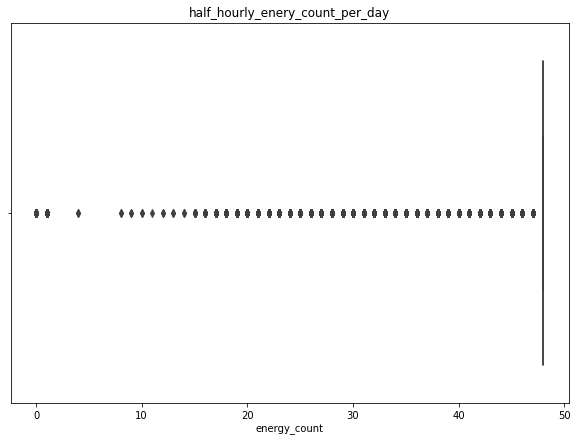

In [6]:
fig, ax = plt.subplots(figsize=(10,7))
sns.boxplot(daily['energy_count'])
plt.title("half_hourly_enery_count_per_day")
plt.savefig("half_hourly_count")

In [7]:
cum_freq = []
for i in range(1,49):
    cum_freq.append(np.sum(daily['energy_count']<=i)/len(daily))
    print("no. of imstances having daily count less than {} is {}".format(i, np.sum(daily['energy_count']<=i)/len(daily)))

no. of imstances having daily count less than 1 is 0.003227806940055543
no. of imstances having daily count less than 2 is 0.003227806940055543
no. of imstances having daily count less than 3 is 0.003227806940055543
no. of imstances having daily count less than 4 is 0.0032283766703423765
no. of imstances having daily count less than 5 is 0.0032283766703423765
no. of imstances having daily count less than 6 is 0.0032283766703423765
no. of imstances having daily count less than 7 is 0.0032283766703423765
no. of imstances having daily count less than 8 is 0.0032289464006292103
no. of imstances having daily count less than 9 is 0.0032295161309160436
no. of imstances having daily count less than 10 is 0.0032300858612028774
no. of imstances having daily count less than 11 is 0.003230370726346294
no. of imstances having daily count less than 12 is 0.0032309404566331274
no. of imstances having daily count less than 13 is 0.0032315101869199612
no. of imstances having daily count less than 14 is

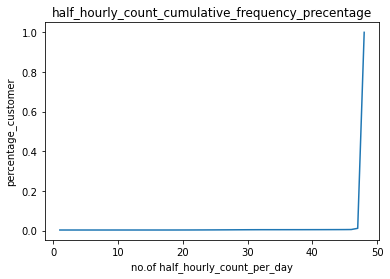

In [8]:
plt.plot(range(1,49), cum_freq)
plt.title("half_hourly_count_cumulative_frequency_precentage")
plt.xlabel("no.of half_hourly_count_per_day") 
plt.ylabel("percentage_customer")
plt.savefig("cum_percentage_customer")

From the above plots and percentages we found that almost 99.99 precent people have all 48 half hourly counts per day **so we can drop those 0.01 percentage rows** as it is a nominal count.

This dropping will result in the removal of 6 IDS, which is nominal while analysing all remaining 5660 IDs

In [9]:
# dropping those rows which not have 48 hal_hourly count
daily = daily.drop(daily[(daily["energy_count"]<=47)].index.values, axis = 0)

In [10]:
daily.isnull().sum()

LCLid            0
day              0
energy_median    0
energy_mean      0
energy_max       0
energy_count     0
energy_std       0
energy_sum       0
energy_min       0
dtype: int64

In [11]:
daily

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
1,MAC000131,2011-12-16,0.1415,0.296167,1.116,48,0.281471,14.216,0.031
2,MAC000131,2011-12-17,0.1015,0.189812,0.685,48,0.188405,9.111,0.064
3,MAC000131,2011-12-18,0.1140,0.218979,0.676,48,0.202919,10.511,0.065
4,MAC000131,2011-12-19,0.1910,0.325979,0.788,48,0.259205,15.647,0.066
5,MAC000131,2011-12-20,0.2180,0.357500,1.077,48,0.287597,17.160,0.066
...,...,...,...,...,...,...,...,...,...
3510427,MAC004977,2014-02-23,0.1365,0.174646,0.754,48,0.151583,8.383,0.046
3510428,MAC004977,2014-02-24,0.0950,0.118458,0.580,48,0.093814,5.686,0.052
3510429,MAC004977,2014-02-25,0.0675,0.084208,0.176,48,0.037107,4.042,0.046
3510430,MAC004977,2014-02-26,0.1080,0.120500,0.282,48,0.069332,5.784,0.046


### ID analysis on basis of data of total days count

C:\Users\SanthoshkumarSambamo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


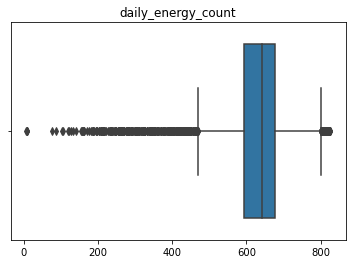

In [12]:
# plotting and finding outliers in daily_counts
sns.boxplot(daily.groupby("LCLid").size())
plt.title("daily_energy_count")
plt.savefig("daily_energy_count_boxplot")

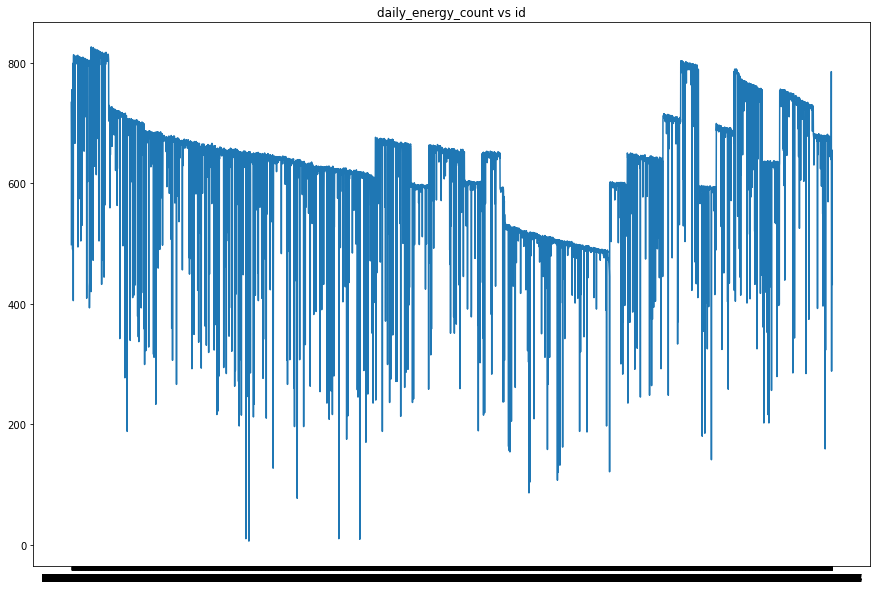

In [13]:
#particular ids count
plt.figure(figsize = (15,10))
daily_count = daily.groupby("LCLid").size()
plt.plot(daily_count.index, daily_count.values)
plt.title("daily_energy_count vs id")
plt.savefig("daily_energy_count vs id")

**Now we found that some of the ids have large duration which represents more instances, so we need to decide one period(Generally one year) where maximum number of ids will have enteries, so that the analysis can be fruitful**

In [14]:
# Now printing final unique_values
daily.isnull().sum()

LCLid            0
day              0
energy_median    0
energy_mean      0
energy_max       0
energy_count     0
energy_std       0
energy_sum       0
energy_min       0
dtype: int64

In [15]:
grpby = daily.groupby("LCLid").size()
list_devices = list(grpby[grpby<=250].index)
print("Households below this threshold: {} households".format(len(list_devices)))

Households below this threshold: 69 households


In [16]:
daily

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
1,MAC000131,2011-12-16,0.1415,0.296167,1.116,48,0.281471,14.216,0.031
2,MAC000131,2011-12-17,0.1015,0.189812,0.685,48,0.188405,9.111,0.064
3,MAC000131,2011-12-18,0.1140,0.218979,0.676,48,0.202919,10.511,0.065
4,MAC000131,2011-12-19,0.1910,0.325979,0.788,48,0.259205,15.647,0.066
5,MAC000131,2011-12-20,0.2180,0.357500,1.077,48,0.287597,17.160,0.066
...,...,...,...,...,...,...,...,...,...
3510427,MAC004977,2014-02-23,0.1365,0.174646,0.754,48,0.151583,8.383,0.046
3510428,MAC004977,2014-02-24,0.0950,0.118458,0.580,48,0.093814,5.686,0.052
3510429,MAC004977,2014-02-25,0.0675,0.084208,0.176,48,0.037107,4.042,0.046
3510430,MAC004977,2014-02-26,0.1080,0.120500,0.282,48,0.069332,5.784,0.046


In [17]:
final = daily.groupby("LCLid").mean().reset_index()


In [18]:
final

,LCLid,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
0,MAC000002,0.186374,0.252002,1.084564,48.0,0.207510,12.096094,0.077647
1,MAC000003,0.169301,0.396798,1.867844,48.0,0.480717,19.046328,0.054533
2,MAC000004,0.000303,0.035384,0.237020,48.0,0.072221,1.698431,0.000062
3,MAC000005,0.050711,0.095424,0.590945,48.0,0.108936,4.580369,0.028745
4,MAC000006,0.049047,0.059515,0.249658,48.0,0.046019,2.856742,0.013093
...,...,...,...,...,...,...,...,...
5555,MAC005561,0.106643,0.152602,0.607604,48.0,0.128071,7.324903,0.033074
5556,MAC005562,0.180876,0.217982,0.836276,48.0,0.159403,10.463156,0.067511
5557,MAC005564,0.064813,0.083853,0.556137,48.0,0.094026,4.024940,0.010958
5558,MAC005566,0.352392,0.363009,0.876581,48.0,0.182109,17.424417,0.128589


In [19]:
final.drop('LCLid', axis = 1, inplace = True)


In [20]:
final

,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
0,0.186374,0.252002,1.084564,48.0,0.207510,12.096094,0.077647
1,0.169301,0.396798,1.867844,48.0,0.480717,19.046328,0.054533
2,0.000303,0.035384,0.237020,48.0,0.072221,1.698431,0.000062
3,0.050711,0.095424,0.590945,48.0,0.108936,4.580369,0.028745
4,0.049047,0.059515,0.249658,48.0,0.046019,2.856742,0.013093
...,...,...,...,...,...,...,...
5555,0.106643,0.152602,0.607604,48.0,0.128071,7.324903,0.033074
5556,0.180876,0.217982,0.836276,48.0,0.159403,10.463156,0.067511
5557,0.064813,0.083853,0.556137,48.0,0.094026,4.024940,0.010958
5558,0.352392,0.363009,0.876581,48.0,0.182109,17.424417,0.128589


In [21]:
final.columns[1:2]

Index(['energy_mean'], dtype='object')

## 3. Clustering

Now we will perform Agglomerative clustering with cluster value = 3 as from our other analysis

In [22]:
from sklearn.cluster import AgglomerativeClustering as ac
cluster=ac(n_clusters=3, affinity='euclidean', linkage='ward')
arr = pd.DataFrame(cluster.fit_predict(final[final.columns[1:2]])) # base on mean energy
arr

,0
0,2
1,2
2,1
3,1
4,1
...,...
5555,1
5556,2
5557,1
5558,2


In [23]:
arr

,0
0,2
1,2
2,1
3,1
4,1
...,...
5555,1
5556,2
5557,1
5558,2


C:\Users\SanthoshkumarSambamo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


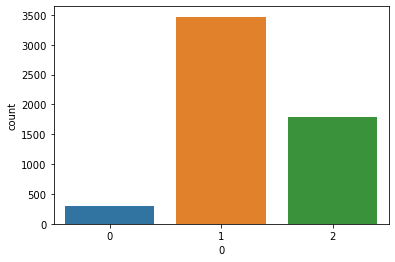

In [24]:
sns.countplot(arr[0])
plt.savefig("cluster_maps")

## 4. Data Manipulation

In [25]:
# based on this clustering we will choose the middle one for data manipulation

arr.value_counts()


1    3471
2    1796
0     293
dtype: int64

In [26]:
# Now we will randomly pick around 600 ids from cluster 1 for transformation
transform_indexes = list(arr[arr[0]==1].sample(600, random_state = 2).index)

# dividing these transformation into three types and appyling different transformations on it
in1 = transform_indexes[0:200]
in2 = transform_indexes[200:400]
in3 = transform_indexes[400:]



In [27]:
theft1 = final[final.index.isin(in1)].reset_index(drop = True)
theft2 = final[final.index.isin(in2)].reset_index(drop = True)
theft3 = final[final.index.isin(in3)].reset_index(drop = True)


In [28]:
theft1

,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
0,0.000000,0.001681,0.076152,48.0,0.011098,0.080689,0.000000
1,0.137063,0.158157,0.478674,48.0,0.089856,7.591528,0.058205
2,0.132022,0.214111,0.747613,48.0,0.191505,10.277336,0.063565
3,0.114363,0.135706,0.474800,48.0,0.081797,6.513869,0.051886
4,0.073483,0.088873,0.300436,48.0,0.065782,4.265914,0.020455
...,...,...,...,...,...,...,...
195,0.136808,0.169588,1.068025,48.0,0.191565,8.140218,0.040265
196,0.099519,0.141664,0.883576,48.0,0.155438,6.799864,0.043109
197,0.067381,0.117365,0.627050,48.0,0.136802,5.633520,0.005615
198,0.073536,0.093546,0.306169,48.0,0.062132,4.490224,0.024159


In [29]:
# Using standard normal distribution for transformation one number per row
for i in range(len(theft1)):
    val=np.random.rand()
    for k, va in theft1.iteritems():
        theft1[k][i]= theft1[k][i]*val

# Using beta distribution for transformation one number per row
for i in range(len(theft2)):
    val=np.random.beta(0.2, 0.5)
    for k, va in theft2.iteritems():
        theft2[k][i]= theft2[k][i]*val

# Using gamma distribution for transformation one number per row
for i in range(len(theft3)):
    val=np.random.gamma(2,3)
    for k, va in theft3.iteritems():
        theft3[k][i]= theft3[k][i]*val


In [30]:
theft1['label'] = 1         #unfaithfull
theft2['label'] = 1
theft3['label'] = 1

final['label'] = 0          #faithfull

data =pd.concat([final,theft1,theft2,theft3]).reset_index(drop=  True)

In [31]:
data

,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min,label
0,0.186374,0.252002,1.084564,48.000000,0.207510,12.096094,0.077647,0
1,0.169301,0.396798,1.867844,48.000000,0.480717,19.046328,0.054533,0
2,0.000303,0.035384,0.237020,48.000000,0.072221,1.698431,0.000062,0
3,0.050711,0.095424,0.590945,48.000000,0.108936,4.580369,0.028745,0
4,0.049047,0.059515,0.249658,48.000000,0.046019,2.856742,0.013093,0
...,...,...,...,...,...,...,...,...
6155,0.531968,0.667153,2.817762,353.664803,0.537632,32.023365,0.152265,1
6156,1.781889,2.767567,13.297714,740.850524,2.780082,132.843238,0.604991,1
6157,0.623238,1.178415,7.989800,436.140820,1.666416,56.563898,0.010286,1
6158,0.491210,0.575523,1.696118,168.564556,0.385352,27.625118,0.153628,1


## 5. Model Building

In [32]:
data

,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min,label
0,0.186374,0.252002,1.084564,48.000000,0.207510,12.096094,0.077647,0
1,0.169301,0.396798,1.867844,48.000000,0.480717,19.046328,0.054533,0
2,0.000303,0.035384,0.237020,48.000000,0.072221,1.698431,0.000062,0
3,0.050711,0.095424,0.590945,48.000000,0.108936,4.580369,0.028745,0
4,0.049047,0.059515,0.249658,48.000000,0.046019,2.856742,0.013093,0
...,...,...,...,...,...,...,...,...
6155,0.531968,0.667153,2.817762,353.664803,0.537632,32.023365,0.152265,1
6156,1.781889,2.767567,13.297714,740.850524,2.780082,132.843238,0.604991,1
6157,0.623238,1.178415,7.989800,436.140820,1.666416,56.563898,0.010286,1
6158,0.491210,0.575523,1.696118,168.564556,0.385352,27.625118,0.153628,1


In [33]:
data[data['label']==1].shape

(600, 8)

In [34]:
data[data['label']==0].shape

(5560, 8)

In [35]:
data

,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min,label
0,0.186374,0.252002,1.084564,48.000000,0.207510,12.096094,0.077647,0
1,0.169301,0.396798,1.867844,48.000000,0.480717,19.046328,0.054533,0
2,0.000303,0.035384,0.237020,48.000000,0.072221,1.698431,0.000062,0
3,0.050711,0.095424,0.590945,48.000000,0.108936,4.580369,0.028745,0
4,0.049047,0.059515,0.249658,48.000000,0.046019,2.856742,0.013093,0
...,...,...,...,...,...,...,...,...
6155,0.531968,0.667153,2.817762,353.664803,0.537632,32.023365,0.152265,1
6156,1.781889,2.767567,13.297714,740.850524,2.780082,132.843238,0.604991,1
6157,0.623238,1.178415,7.989800,436.140820,1.666416,56.563898,0.010286,1
6158,0.491210,0.575523,1.696118,168.564556,0.385352,27.625118,0.153628,1


In [36]:
X = data.drop(['label'], axis = 1)
y = data['label']

In [37]:
X

,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
0,0.186374,0.252002,1.084564,48.000000,0.207510,12.096094,0.077647
1,0.169301,0.396798,1.867844,48.000000,0.480717,19.046328,0.054533
2,0.000303,0.035384,0.237020,48.000000,0.072221,1.698431,0.000062
3,0.050711,0.095424,0.590945,48.000000,0.108936,4.580369,0.028745
4,0.049047,0.059515,0.249658,48.000000,0.046019,2.856742,0.013093
...,...,...,...,...,...,...,...
6155,0.531968,0.667153,2.817762,353.664803,0.537632,32.023365,0.152265
6156,1.781889,2.767567,13.297714,740.850524,2.780082,132.843238,0.604991
6157,0.623238,1.178415,7.989800,436.140820,1.666416,56.563898,0.010286
6158,0.491210,0.575523,1.696118,168.564556,0.385352,27.625118,0.153628


In [38]:
from sklearn.model_selection import train_test_split

In [39]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x = sc.fit_transform(X)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [41]:
print(x.shape)
print(X_train.shape)
 
print(X_test.shape)

(6160, 7)
(4928, 7)
(1232, 7)


In [42]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import BatchNormalization,Dropout

In [43]:
model = Sequential()
model.add(Dense(10, input_dim=7, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(7, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.25))

model.add(Dense(4, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.25))

model.add(Dense(1, activation='sigmoid'))

In [44]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [45]:
history = model.fit(X_train, y_train,validation_data = (X_test,y_test), epochs=100, batch_size=64)

Epoch 1/100
77/77 [==============================] - 1s 6ms/step - loss: 0.6924 - accuracy: 0.5946 - val_loss: 0.6157 - val_accuracy: 0.9472
Epoch 2/100
77/77 [==============================] - 0s 2ms/step - loss: 0.5544 - accuracy: 0.7867 - val_loss: 0.4956 - val_accuracy: 0.9537
Epoch 3/100
77/77 [==============================] - 0s 3ms/step - loss: 0.4729 - accuracy: 0.8547 - val_loss: 0.4094 - val_accuracy: 0.9594
Epoch 4/100
77/77 [==============================] - 0s 2ms/step - loss: 0.4098 - accuracy: 0.9056 - val_loss: 0.3391 - val_accuracy: 0.9610
Epoch 5/100
77/77 [==============================] - 0s 3ms/step - loss: 0.3542 - accuracy: 0.9320 - val_loss: 0.2820 - val_accuracy: 0.9635
Epoch 6/100
77/77 [==============================] - 0s 3ms/step - loss: 0.3155 - accuracy: 0.9389 - val_loss: 0.2343 - val_accuracy: 0.9627
Epoch 7/100
77/77 [==============================] - 0s 2ms/step - loss: 0.2796 - accuracy: 0.9403 - val_loss: 0.1975 - val_accuracy: 0.9659
Epoch 8/100
7

Epoch 59/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0523 - accuracy: 0.9899 - val_loss: 0.0306 - val_accuracy: 0.9935
Epoch 60/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0552 - accuracy: 0.9905 - val_loss: 0.0298 - val_accuracy: 0.9943
Epoch 61/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0501 - accuracy: 0.9905 - val_loss: 0.0322 - val_accuracy: 0.9943
Epoch 62/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0546 - accuracy: 0.9886 - val_loss: 0.0323 - val_accuracy: 0.9943
Epoch 63/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0500 - accuracy: 0.9899 - val_loss: 0.0294 - val_accuracy: 0.9951
Epoch 64/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0469 - accuracy: 0.9907 - val_loss: 0.0325 - val_accuracy: 0.9935
Epoch 65/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0542 - accuracy: 0.9892 - val_loss: 0.0262 - val_accuracy: 0.9951
Epoch 

In [46]:
import pickle

In [47]:
pickle.dump(sc, open('StandardScaler.pk', 'wb'))

In [48]:
sc = pickle.load(open('StandardScaler.pk', 'rb'))

In [49]:
model.save('theft.h5')

In [50]:
y_pred =  model.predict(X_test)

39/39 [==============================] - 0s 1ms/step


In [51]:
import numpy as np
y_pred.shape
y_pred = np.round(y_pred)

In [52]:
import sklearn.metrics as metrics
print(metrics.accuracy_score(y_pred,y_test))

0.9951298701298701


<AxesSubplot:>

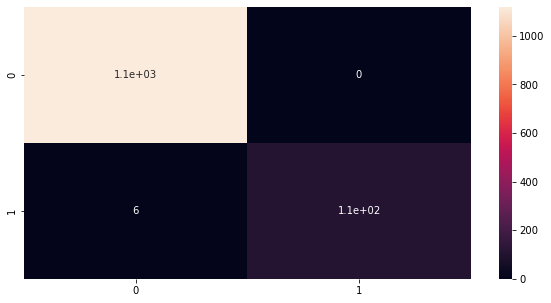

In [53]:
import seaborn as sns
plt.figure(figsize=(10,5))
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,annot=True)

In [54]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1119
           1       1.00      0.95      0.97       113

    accuracy                           1.00      1232
   macro avg       1.00      0.97      0.99      1232
weighted avg       1.00      1.00      1.00      1232

